In [ ]:
!nvidia-smi

In [ ]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_folders = sorted(glob('C:\\Users\\Hp\\Mango\\Mango\\*'))

In [ ]:
len(train_folders)

4

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img

In [ ]:
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

In [ ]:
def show_leaf(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(16, 8))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

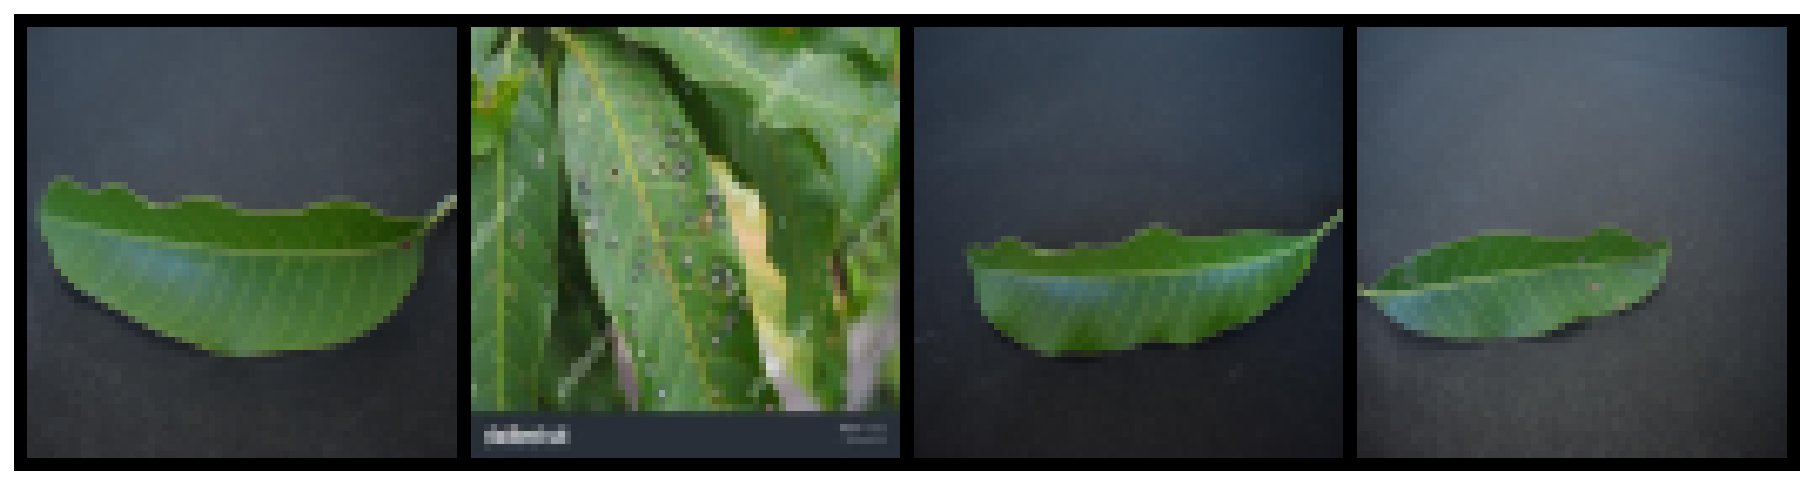

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*.JPG')) for tf in train_folders]
show_leaf(sample_images)

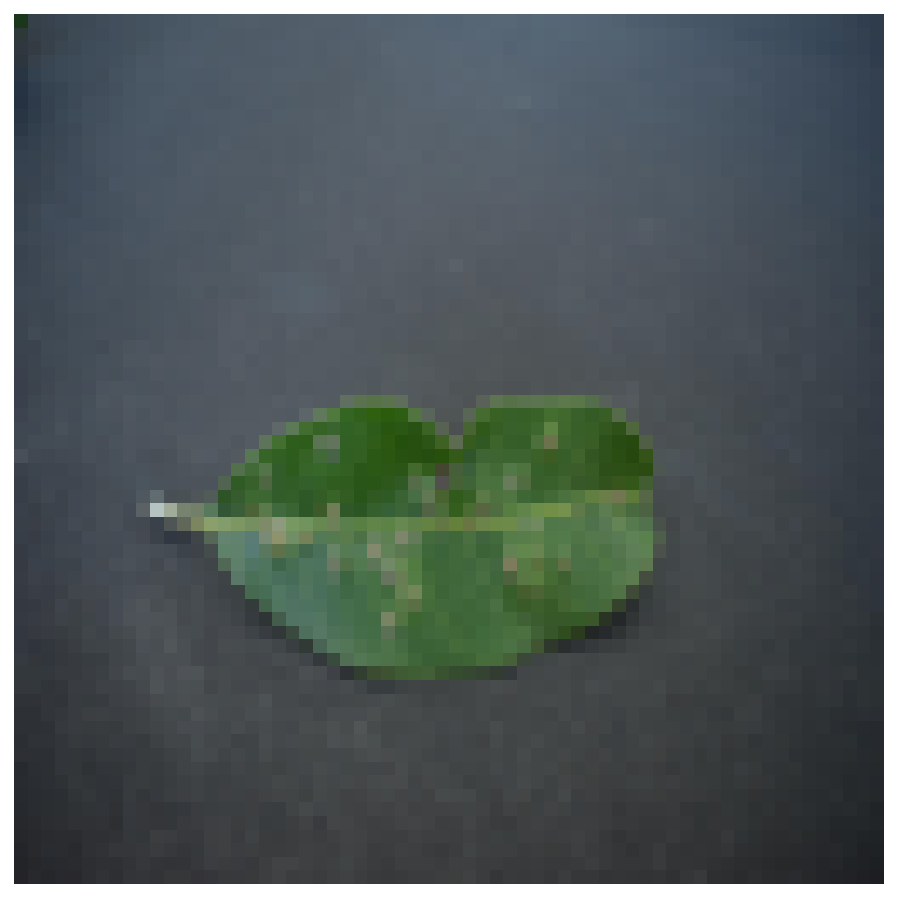

In [ ]:
img_path = glob(f'{train_folders[1]}/*.JPG')[1]

show_image(img_path)

In [ ]:
class_names = ['Anthacnose', 'Gall Midge', 'Healthy', 'Powdary_Mildew']
class_indices=[0, 1, 2, 3]

In [ ]:

DATA_DIR = Path('E:\\Mangofinal++')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.JPG'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

Anthacnose: 243
Gall Midge: 29
Healthy: 269
Powdary_Mildew: 44


In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  #T.RandomResizedCrop(size=256),
  T.Resize(size=(256, 256)),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  #T.RandomVerticalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=(256, 256)),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=(256, 256)),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=0) 
  for d in DATASETS
}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 467, 'val': 58, 'test': 60}

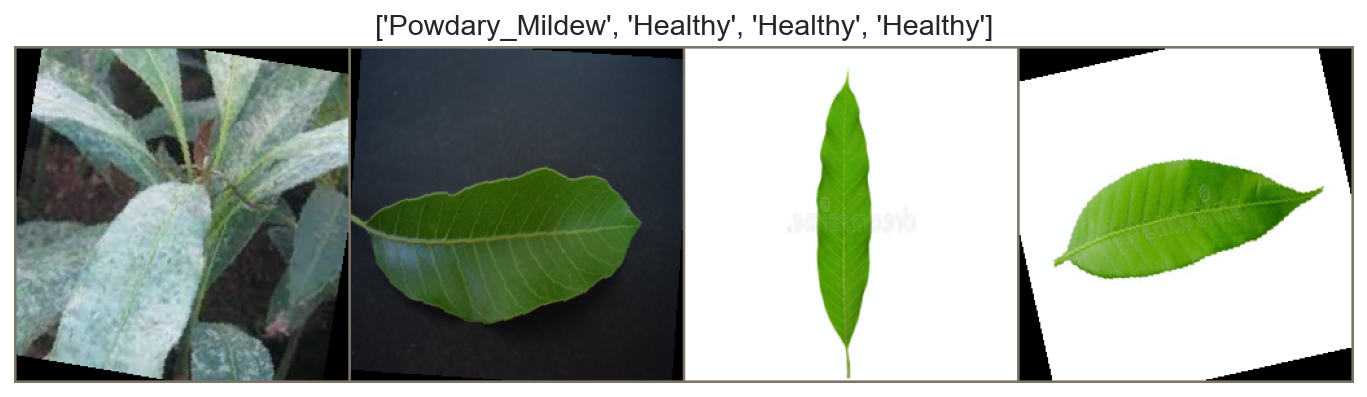

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
class model(nn.Module):
  def __init__(self, num_classes= 4):
    super(model, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride = 1, padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, stride = 1, padding=0),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =2)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(32, 32, kernel_size=3, stride = 1, padding=0),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =1)
    )
    self.layer4 = nn.Sequential(
        nn.Conv2d(32, 32, kernel_size=7, stride = 1, padding=0),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =1)
    )
    self.layer5 = nn.Sequential(
        nn.Conv2d(32, 32, kernel_size=3, stride = 1, padding=0),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =2)
    )
    self.fc = nn.Linear(25*25*32, num_classes)
    

  def forward(self, x):
     #print(x.shape)
     out = self.layer1(x)
     #print(out.shape)
     out = self.layer2(out)
     #print(out.shape) 
     out = self.layer3(out)
     #print(out.shape)
     out = self.layer4(out)
     #print(out.shape)
     out = self.layer5(out)
     # print('layer 5 output: '+str(out.shape))
     out= out.reshape(out.size(0), -1)
     #print(out.shape) 
     out = self.fc(out)
     
     return out 

In [ ]:
model = model().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=30):

      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.6)
      scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
      loss_fn = nn.CrossEntropyLoss().to(device)
      history = defaultdict(list)
      best_accuracy = 0

      for epoch in range(n_epochs):

        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
          model,
          data_loaders['train'],    
          loss_fn, 
          optimizer, 
          device, 
          scheduler, 
          dataset_sizes['train']
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
          model,
          data_loaders['val'],
          loss_fn,
          device,
          dataset_sizes['val']
        )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
          torch.save(model.state_dict(), 'best_model_state.bin')
          best_accuracy = val_acc

      print(f'Best val accuracy: {best_accuracy}')
      
      model.load_state_dict(torch.load('best_model_state.bin'))

      return model, history

In [ ]:
model, history = train_model(model, data_loaders, dataset_sizes, device)

Epoch 1/30
----------
Train loss 2.1947112650188627 accuracy 0.6167023554603854
Val   loss 0.7803816239039103 accuracy 0.8275862068965517

Epoch 2/30
----------
Train loss 0.8117698902248317 accuracy 0.7323340471092077
Val   loss 1.7152773678302764 accuracy 0.7068965517241379

Epoch 3/30
----------
Train loss 0.8482127836626819 accuracy 0.721627408993576
Val   loss 0.5268366992473602 accuracy 0.8620689655172413

Epoch 4/30
----------
Train loss 0.7415527142265923 accuracy 0.7430406852248393
Val   loss 0.5997447152932485 accuracy 0.8448275862068966

Epoch 5/30
----------
Train loss 0.9232938549457452 accuracy 0.5931477516059958
Val   loss 1.0468757192293803 accuracy 0.4482758620689655

Epoch 6/30
----------
Train loss 0.7065836833073542 accuracy 0.7366167023554604
Val   loss 0.5155642211437226 accuracy 0.8448275862068966

Epoch 7/30
----------
Train loss 0.6673311079159762 accuracy 0.7858672376873662
Val   loss 0.5261726776758829 accuracy 0.8448275862068966

Epoch 8/30
----------
Train 

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

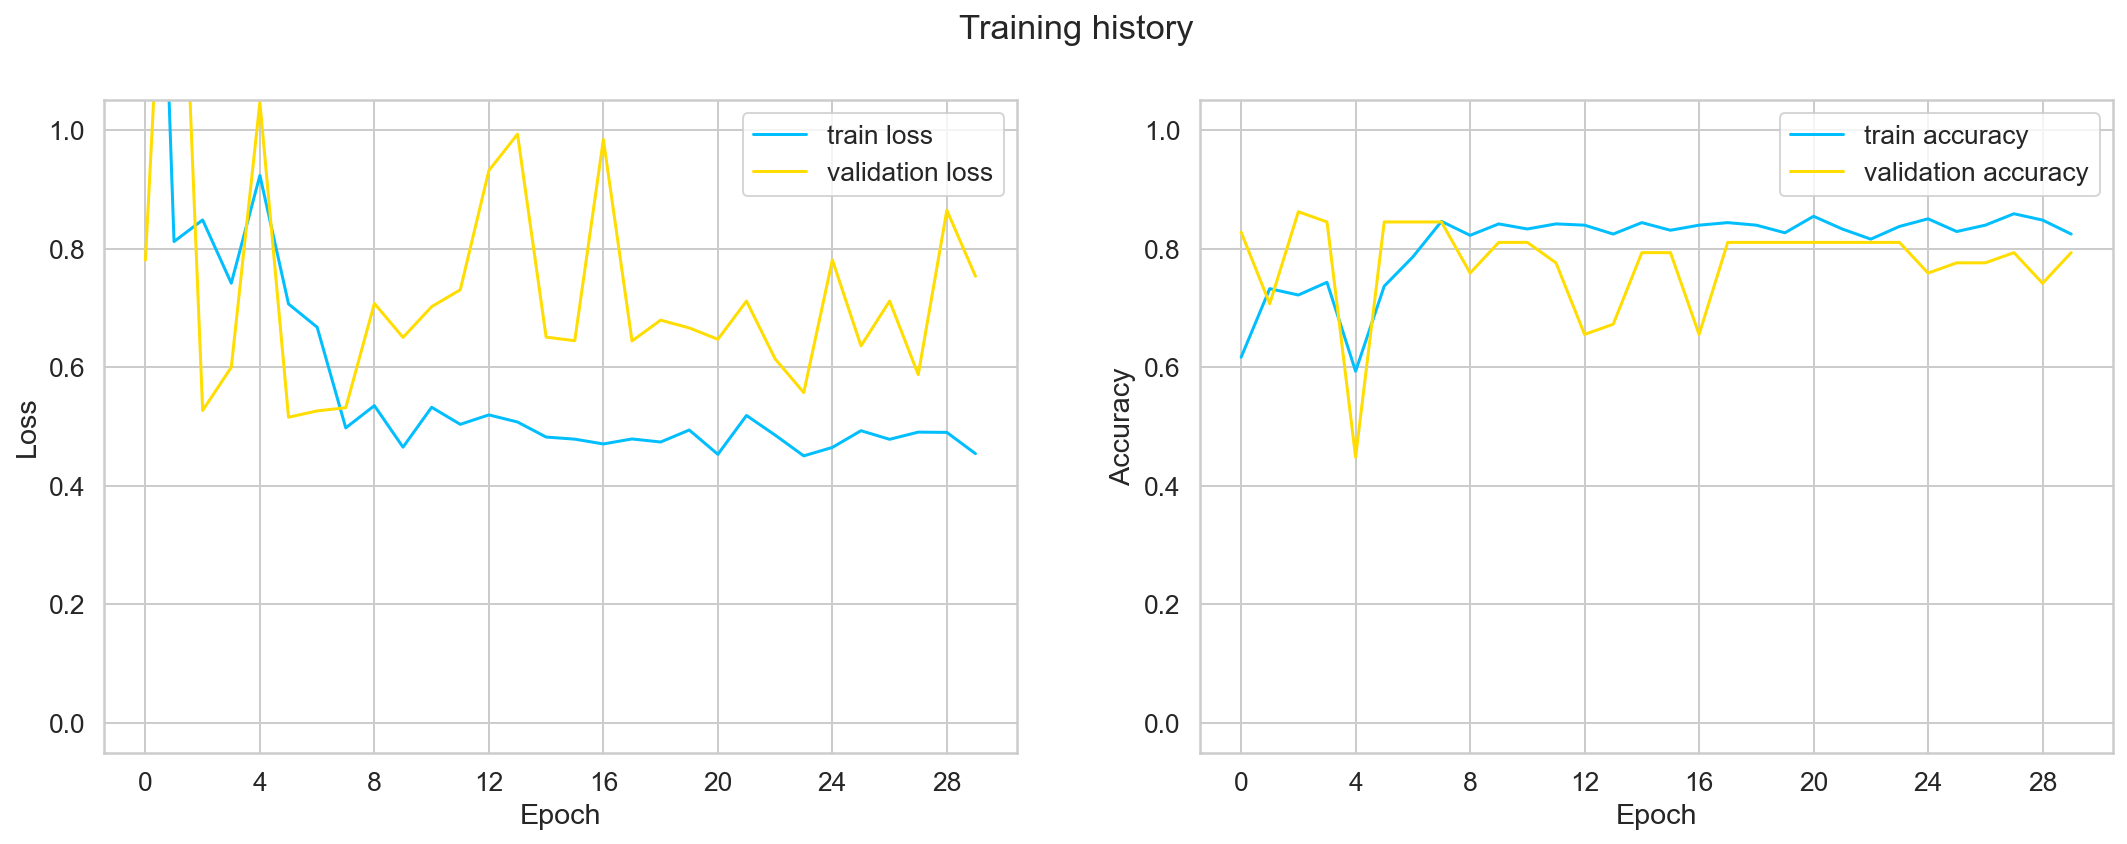

In [ ]:
plot_training_history(history)

In [ ]:
def show_predictions(model, class_names, n_images=8):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

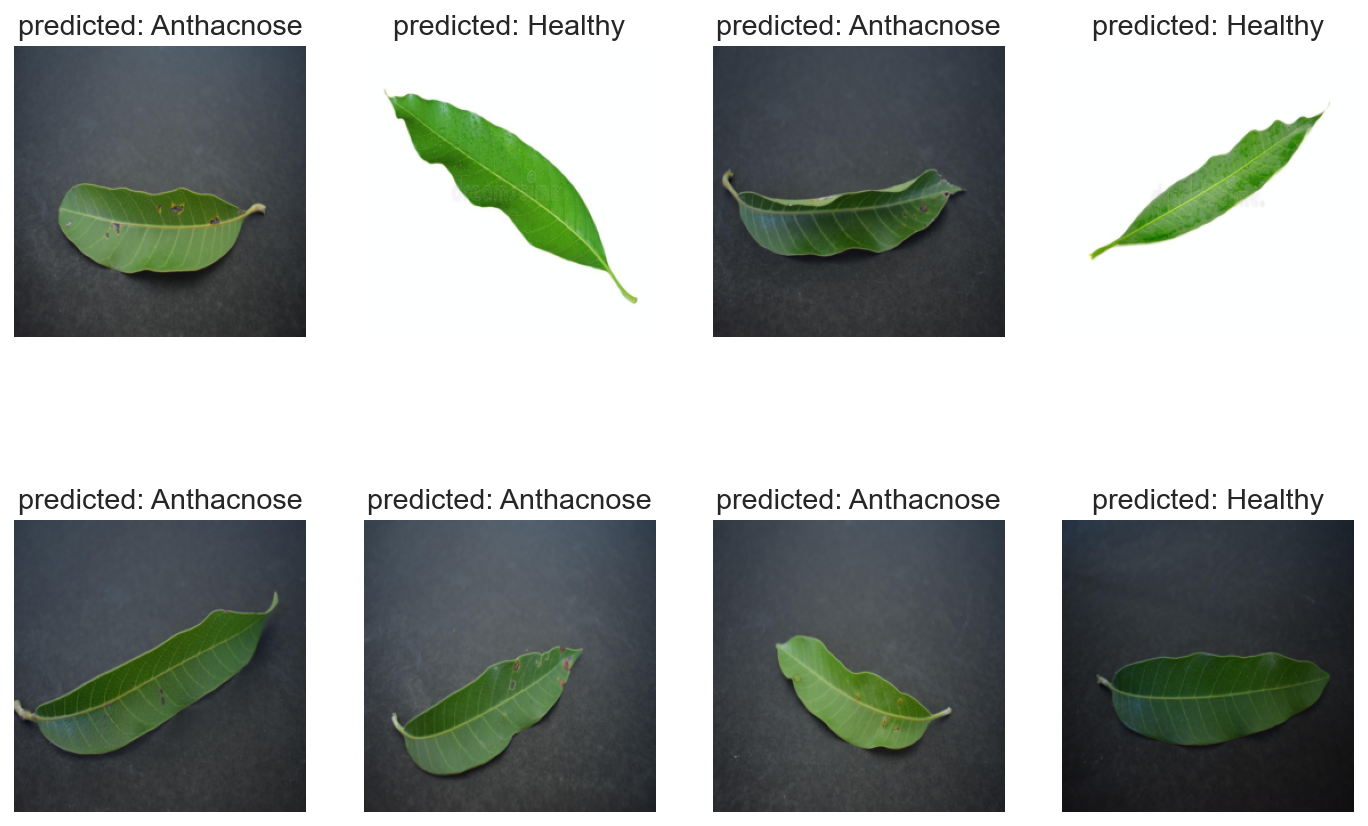

In [ ]:
show_predictions(model, class_names, n_images=8)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_true = get_predictions(model, data_loaders['test'])

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

                precision    recall  f1-score   support

    Anthacnose       0.75      0.96      0.84        25
    Gall Midge       0.00      0.00      0.00         3
       Healthy       0.96      1.00      0.98        27
Powdary_Mildew       0.00      0.00      0.00         5

      accuracy                           0.85        60
     macro avg       0.43      0.49      0.46        60
  weighted avg       0.75      0.85      0.79        60



C:\Users\Hp\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import torch
mae_loss = torch.nn.L1Loss()
input = torch.Tensor.float(y_pred)
target = torch.Tensor.float(y_true)
output = mae_loss(input, target)
print('MAE:',output)

MAE: tensor(0.3333)


In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

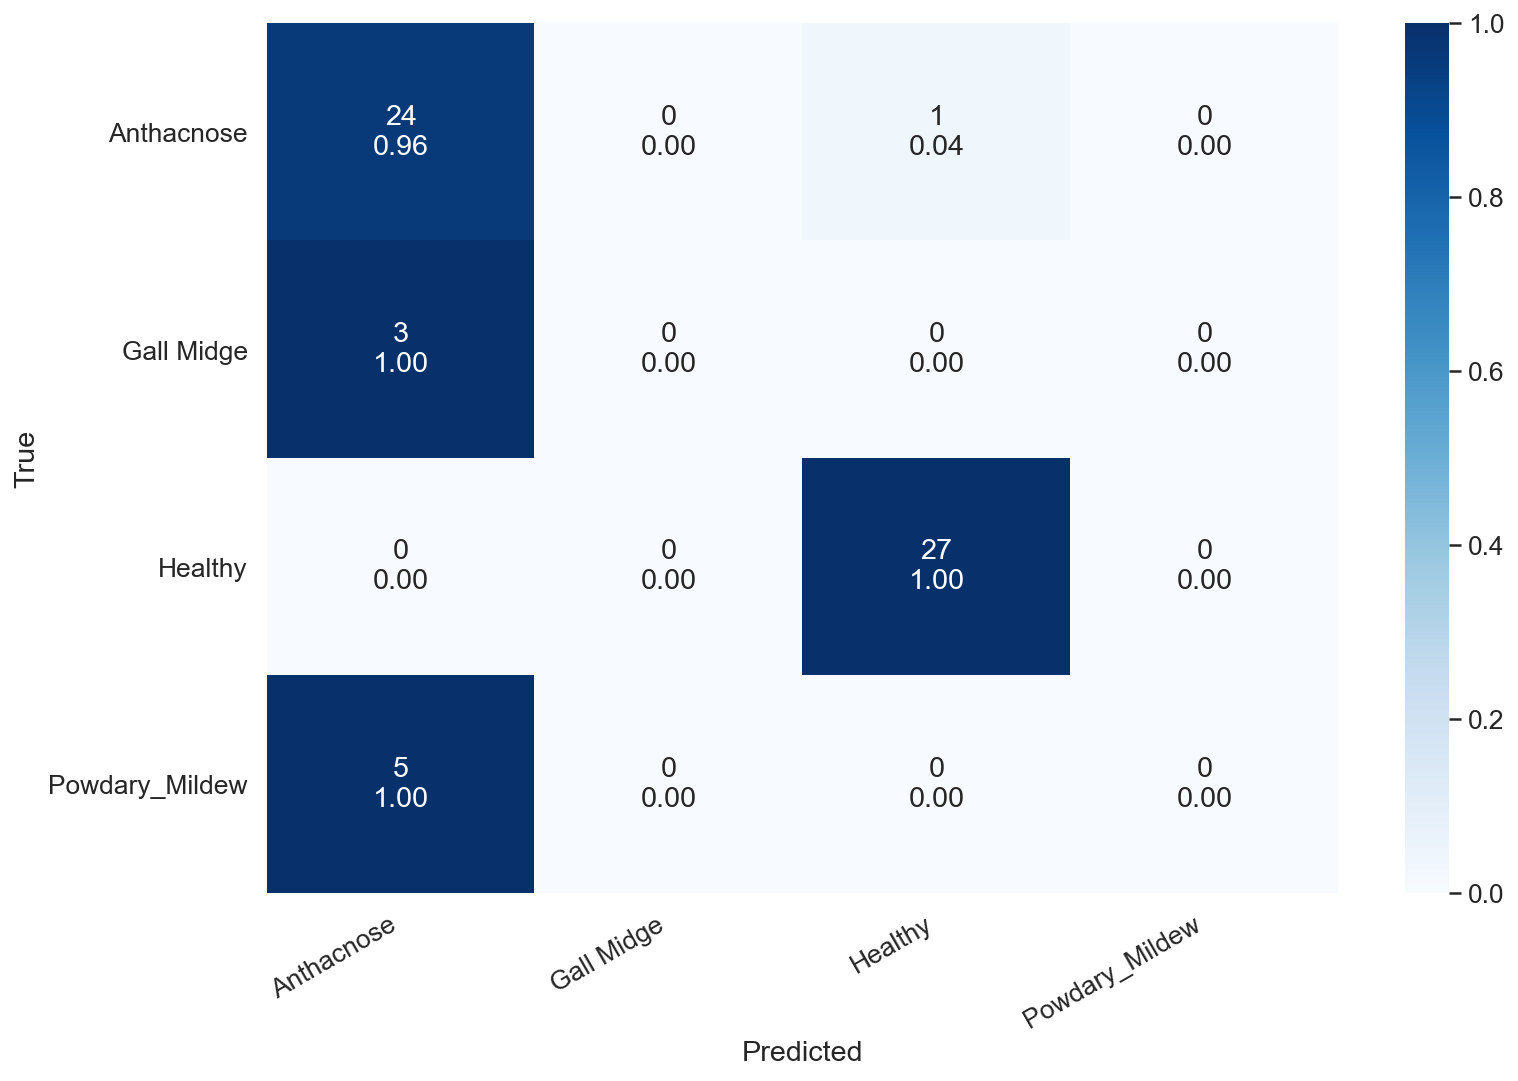

In [ ]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

In [ ]:
leaf= 'C:\\Users\\Hp\\istockphoto.jpg'

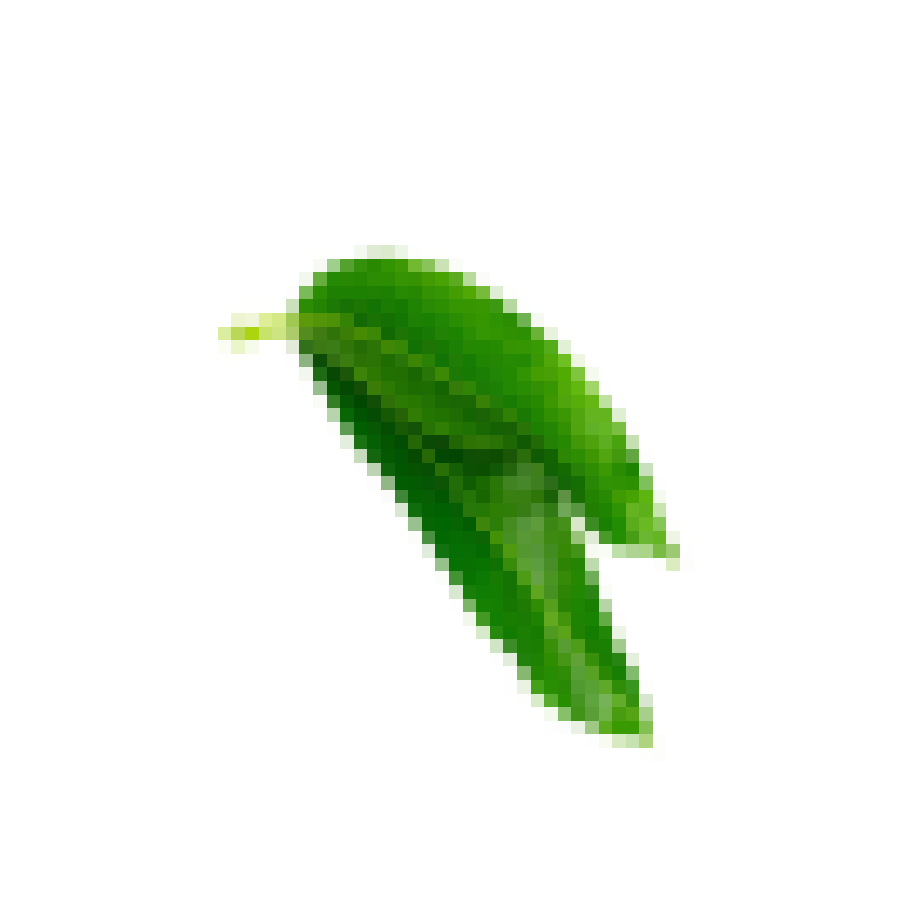

In [ ]:
show_image(leaf)

In [ ]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [ ]:
pred = predict_proba(model, leaf)
pred

array([0.07344919, 0.02101334, 0.88378954, 0.02174784], dtype=float32)

In [ ]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

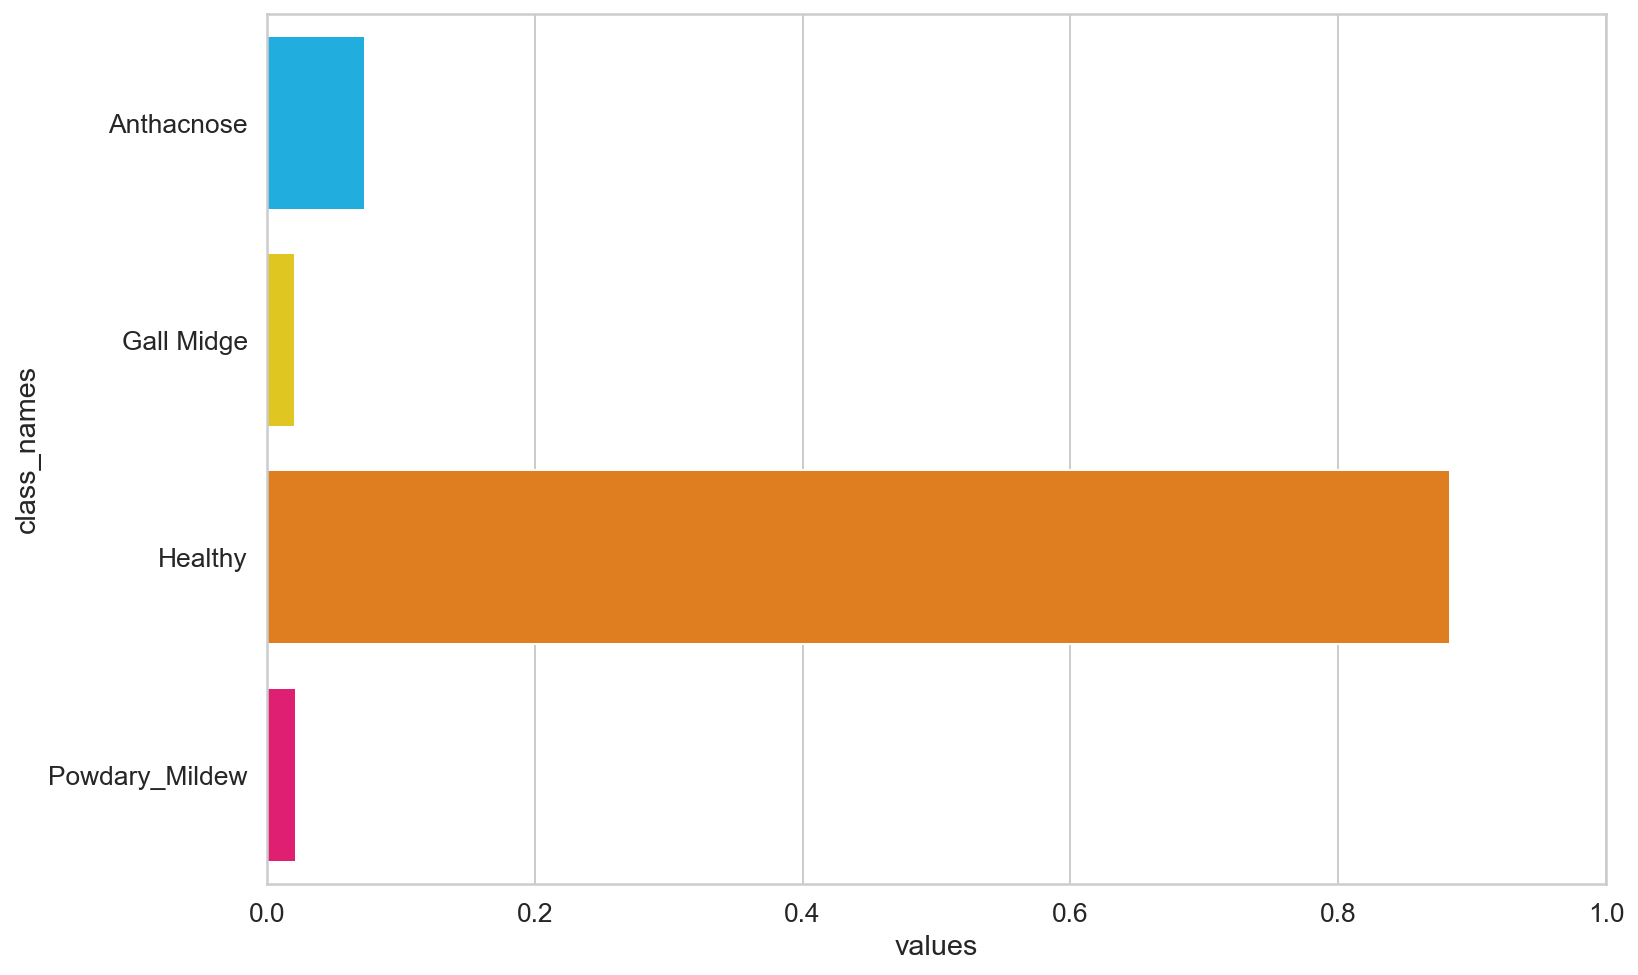

In [ ]:
show_prediction_confidence(pred, class_names)